In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions.frequentist import optimal_statistic
from enterprise_extensions import models, model_utils, hypermodel

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from simFuncs import *
from enterprisePTAs import crnPTA, mcSample
from OS_and_plotting import HandD,Dipole,Monopole,plotBinnedCrossCor

In [ ]:
parfiles = sorted(glob.glob('mdc2/*.par'))
obstimes = 53000.0 + np.linspace(0.0,20.0,520) * 365.25

ltpsrs = create_psrs(parfiles,obstimes,toaerr=0.01)
add_gwb(ltpsrs,amp=1e-14)
psrs = lt2ent(ltpsrs)

In [29]:
pta = crnPTA(psrs,fixedGamma=True)

In [30]:
OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                        orf='hd',pta=pta)


In [31]:
xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
print(os,os_sig)
print(os/os_sig)

1.455462416016627e-28 6.65369008769717e-30
21.874514695353955


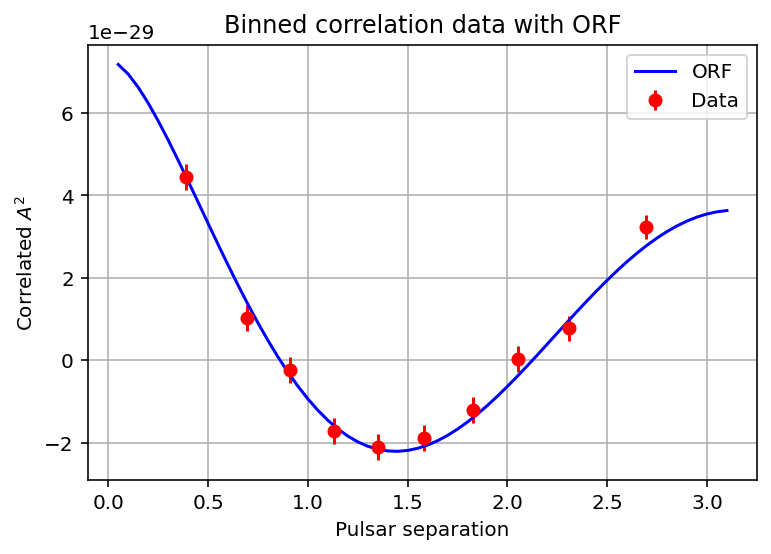

In [32]:
plotBinnedCrossCor(xi,rho,sig,os)

In [4]:
import healpy
import os
nside = 3
theta,phi = healpy.pix2ang(nside,np.arange(0,healpy.nside2npix(nside)))

In [6]:
parfiles = sorted(glob.glob('mdc2/*.par'))
obstimes = 53000.0 + np.linspace(0.0,20.0,520) * 365.25
gwb_amp = 1e-14
toaerr = 0.1
tref = obstimes[0]*86400.0

xi = []
all_rhos = []
all_sigs = []
all_amps = []
all_ampsig = []
for ph,th in zip(phi,theta):
    rhos = []
    sigs = []
    amps = []
    ampsig = []

    for i in range(10):
        ltpsrs = create_psrs(parfiles,obstimes,toaerr=toaerr)
        add_gwb(ltpsrs,amp=gwb_amp)
    
    
        pdict = {'gwtheta': th,
                 'gwphi': ph,
                 'mc': 5e9,
                 'dist': 60., 
                 'fgw': 2e-8,
                 'phase0': 0.0,
                 'psi': np.pi/4.0,
                 'inc': 0.0}
    
        add_cgw(ltpsrs, pdict, tref, iters=5)
    
        psrs = lt2ent(ltpsrs)
    
        pta = crnPTA(psrs,fixedGamma=True)
        OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                            orf='hd',pta=pta)
    
        xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
        
        rhos.append(rho)
        sigs.append(sig)
        amps.append(os)
        ampsig.append(os_sig)
    all_rhos.append(rhos)
    all_sigs.append(sigs)
    all_amps.append(amps)
    all_ampsig.append(ampsig)

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

KeyboardInterrupt: 

In [25]:
import healpy
import os
import warnings
warnings.filterwarnings('ignore')
nside = 2
theta,phi = healpy.pix2ang(nside,np.arange(0,healpy.nside2npix(nside)))
print(len(theta))

48


In [26]:
datadir = '/Users/gersbaka/Documents/Projects/VIPER_SummerSchool/mdc2/'
outdir = '/Users/gersbaka/Documents/Projects/VIPER_SummerSchool/kag_data/'

prun = '/Users/gersbaka/opt/anaconda3/envs/pta_software/bin/python'
all_pars = {'data':datadir,'orf':'hd','mass':5e9,'freq':2e-8,'distance':60,'realizations':10}

for ph,th in zip(phi,theta):
    res = outdir+f'results/run_p{ph}_t{th}/'
    runcommand = f'{prun} combine_run.py -data {all_pars["data"]} -orf {all_pars["orf"]} '
    runcommand+= f'-results {res} -mass {all_pars["mass"]} -freq {all_pars["freq"]} '
    runcommand+= f'-distance {all_pars["distance"]} -realisations {all_pars["realizations"]} '
    runcommand+= f'-theta {th} -phi {ph} >/dev/null 2>&1'
    
    os.system(runcommand)
    break
    